## Importovanie knižníc

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
import shap
from imblearn.pipeline import Pipeline as ImbPipeline
from hiclass.metrics import precision as h_precision, recall as h_recall, f1 as h_f1
import os


## Predspracovanie dát

In [2]:
def preprocess_data(file_path):
    relevant_features = [
        'Vek',
        'Pohlavie',
        'Fajčenie',
        'Alkohol',
        'Hypertenzia',
        'Diabetes mellitus',
        'Kardiovaskulárne ochorenia',
        'Chronické respiračné ochorenia',
        'Renálne ochorenia',
        'Pečeňové ochorenia',
        'Onkologické ochorenia',
        'Imunosupresia',
        'Závažnosť priebehu ochorenia'
    ]

    data = pd.read_excel(file_path, usecols=relevant_features)
    # Odstránenie záznamov s chýbajúcou cieľovou premennou
    data=data.dropna(subset=['Závažnosť priebehu ochorenia'])

    # Konverzia kategórie "Pohlavie" na binárnu formu (one-hot encoding)
    data = pd.get_dummies(data, columns=['Pohlavie'], drop_first=True)

    # Vytvorenie nových cieľových premenných pre modelovanie úmrtnosti a závažnosti
    data["Mortality"] = data["Závažnosť priebehu ochorenia"].apply(lambda x: 1 if x == 3 else 0)
    data["Severity"] = data["Závažnosť priebehu ochorenia"].replace({3: np.nan, 1: 0, 2: 1})

    X = data.drop(columns=['Závažnosť priebehu ochorenia', 'Mortality', 'Severity'])
    y_mortality = data['Mortality']
    y_severity = data['Severity']
    y_true = data['Závažnosť priebehu ochorenia']

    return X, y_mortality, y_severity, y_true



## Trénovanie modelu SVM s využitím pipeline a grid search optimalizácie

In [3]:

def train_svm(X, y, preprocessor, scoring='f1_weighted', random_state=42):

    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        # ('resampler', SMOTE(random_state=random_state)),   # V prípade potreby odstráňte komentáre (vykazuje horšie výsledky)
        ('classifier', SVC(random_state=random_state, probability=True, class_weight='balanced'))
    ])


    # Nastavenie grid search pre hľadanie najlepších hyperparametrov modelu
    param_grid = {
       'classifier__C': [0.1, 1, 10, 100],
        'classifier__kernel': ['linear', 'rbf', 'poly'],
        'classifier__gamma': ['scale', 'auto',0.001, 0.01, 1],
         'classifier__class_weight': [None, 'balanced']
    }

    # Spustenie grid search s 5-násobnou krížovou validáciou
    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring=scoring,
        verbose=2,
        n_jobs=-1
    )

    grid.fit(X, y)
    print("Best parameters:", grid.best_params_)
    return grid.best_estimator_

## Vyhodnotenie predikcií modelu pomocou hierarchických metrík (knižnica hiclass).

In [4]:
def evaluate_predictions(y_true, y_pred):

    # Pomocná funkcia na konverziu tried do formátu vhodného pre hierarchické metriky
    def convert_to_hiclass_format(label):
        if label == 1:
            return ["0", "2"]
        elif label == 2:
            return ["0", "3"]
        elif label == 3:
            return ["1"]


    y_true_h = [convert_to_hiclass_format(label) for label in y_true]
    y_pred_h = [convert_to_hiclass_format(label) for label in y_pred]

    print("\n=== Hierarchical Metrics ===")
    print(f"H-Precision: {h_precision(y_true_h, y_pred_h):.4f}")
    print(f"H-Recall:    {h_recall(y_true_h, y_pred_h):.4f}")
    print(f"H-F1:        {h_f1(y_true_h, y_pred_h):.4f}")


## SHAP
>#### V tejto časti sa generujú a ukladajú hodnoty SHAP, ktoré vysvetľujú dôležitosť jednotlivých vstupných premenných pre rozhodovanie modelu. Tieto hodnoty pomáhajú interpretovať, ktoré atribúty mali najväčší vplyv na predpoveď modelu.

> #### Použili sme len na najlepšie modely pre každú vlnu pandémie

In [5]:
def generate_and_save_shap_svm(pipeline, X_train, feature_level, wave_id,
                                shap_csv_filename="shap_values_svm.csv",
                                shap_image_filename=None, save=False):

    # Získame predspracovanie a klasifikátor z pipeline
    preprocessor = pipeline.named_steps['preprocessor']
    model = pipeline.named_steps['classifier']

    # Aplikujeme predspracovanie na trénovacie dáta
    X_train_transformed = preprocessor.transform(X_train)

    feature_names_raw = preprocessor.get_feature_names_out()
    feature_names_clean = clean_feature_names(feature_names_raw)

    # Definujeme predikčnú funkciu, ktorá vracia pravdepodobnosti
    def model_predict_proba(x):
        return model.predict_proba(x)
    background_data = X_train_transformed

    # Inicializácia SHAP vysvetľovača
    explainer = shap.Explainer(model_predict_proba, background_data, feature_names=feature_names_clean)
    shap_values = explainer(X_train_transformed)

    # Vytvorenie dátového rámca SHAP
    if save:
        shap_df = pd.DataFrame(shap_values.values[:, :, 1], columns=feature_names_clean, index=X_train.index)
        shap_df["level"] = feature_level
        shap_df["wave"] = wave_id
        new_shap_long = shap_df.melt(
            id_vars=["level", "wave"],
            var_name="feature",
            value_name="shap_value",
            ignore_index=False
        )
    # Ak existuje súbor s predchádzajúcimi SHAP hodnotami, načítame ho a vyfiltrujeme duplicitné záznamy
        other_data_df = pd.DataFrame()
        if os.path.exists(shap_csv_filename):
            existing_shap_df = pd.read_csv(shap_csv_filename)
            mask_to_keep = ~((existing_shap_df['level'] == feature_level) & (existing_shap_df['wave'] == wave_id))
            other_data_df = existing_shap_df[mask_to_keep]

        # Spojíme nové SHAP hodnoty s existujúcimi a uložíme do súboru
        final_shap_df_to_save = pd.concat([other_data_df, new_shap_long], ignore_index=True)
        final_shap_df_to_save.to_csv(shap_csv_filename, index=False)


    # Ukladanie grafov
    if shap_image_filename:
        plt.figure()
        shap.summary_plot(shap_values[:, :, 1], X_train_transformed, feature_names=feature_names_clean, show=False)
        if save:
            if(feature_level=="mortality"):
                plt.title('SHAP Dôležitosť príznakov (Predikcia úmrtnosti) ')
            else:
                 plt.title('SHAP Dôležitosť príznakov (Klasifikátor závažnosti u preživších)')
            plt.savefig(shap_image_filename, bbox_inches='tight')

        plt.show()
        plt.close()

## Funkcia na vymazanie prefixov z atribútov, ktoré boli pridané v časti prípravy dát

In [6]:
def clean_feature_names(feature_names):
    cleaned_names = []
    for name in feature_names:
        if name.startswith('scaler__'):
            cleaned_names.append(name.replace('scaler__', ''))
        elif name.startswith('passthrough__'):
            cleaned_names.append(name.replace('passthrough__', ''))
        else:
            cleaned_names.append(name)
    return cleaned_names


## V tejto časti prebieha hlavná príprava, trénovanie  a hodnotenie hierarchického modelu.
 > #### Model je dvojúrovňový - najprv sa predpovedá pravdepodobnosť úmrtia (mortality), a ak pacient nebol predikovaný ako zomrel, pokračuje sa druhým modelom (severity), ktorý určuje závažnosť ochorenia u preživších.

### `Prvá vlna pandémie`

In [7]:
X, y_mortality, y_severity, y_true = preprocess_data('../data/1vlna.xlsx')

# Rozdelenie dát na trénovaciu a testovaciu množinu so stratifikáciou podľa cieľovej premennej úmrtnosti (pretože dáta sú nevyvážené).
X_train, X_test, y_train_mort, y_test_mort = train_test_split(
    X, y_mortality, test_size=0.3, random_state=42, stratify=y_mortality
)

# Definícia predspracovania - normalizuje sa len vek, ostatné premenné zostávajú nezmenené
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), ['Vek']),
    ('passthrough', 'passthrough', X.columns.difference(['Vek']))
])


# Trénovanie modelu pre predikciu úmrtnosti
mort_pipeline = train_svm(X_train, y_train_mort, preprocessor)

# Získanie predpovedí Out-of-Fold (OOF) pre trénovacie dáta pri použití modelu úmrtnosti
oof_predictions = cross_val_predict(
    mort_pipeline, X_train, y_train_mort, cv=5, method='predict'
)

# Tento blok kódu vykonáva filtrovanie trénovacích dát, pričom vyberáme len tie prípady, ktoré model úmrtnosti (mortality)
# predpovedal ako preživšie (0), a zároveň sa u týchto pacientov zaznamenáva úroveň závažnosti v skutočných
# údajoch (to znamená, že skutočne prežili a mali inú úroveň závažnosti ako smrť).'''
# Tieto dáta slúžia ako vstup pre druhý model – klasifikátor závažnosti.

survivor_mask_train_pred_oof = (oof_predictions == 0)
y_train_severity_mask = y_severity.loc[X_train.index].notna()
relevant_mask_train = survivor_mask_train_pred_oof & y_train_severity_mask

X_train_severity = X_train[relevant_mask_train]
y_train_severity = y_severity.loc[X_train.index][relevant_mask_train]

# Trénovanie modelu pre predikciu závažnosti na filtrovaných trénovacích dátach
severity_pipeline = train_svm(X_train_severity, y_train_severity, preprocessor)

# Predikcia umrtnosti (mortality) na testovacej množine
y_pred_mortality_test = mort_pipeline.predict(X_test)
survivor_mask_test = (y_pred_mortality_test == 0)

# Príprava testovacích dát pre druhý model – len tí, ktorí boli predikovaní ako preživší.
X_test_severity = X_test[survivor_mask_test]
y_pred_severity = np.full(len(X_test), np.nan)


# Ak existujú pacienti predikovaní ako preživší, aplikuje sa druhý model a zvýši sa predikovaná hodnota o 1, aby sa hodnoty mapovali späť na pôvodné označenie tried (1 alebo 2).
if not X_test_severity.empty:
    y_pred_severity_survivors = severity_pipeline.predict(X_test_severity)
    y_pred_severity[survivor_mask_test] = y_pred_severity_survivors + 1

# Finalizácia predikcie:
# - pacienti predikovaní ako zomrelí (1. model) dostanú hodnotu 3
# - preživší dostanú predikovanú hodnotu závažnosti (1 alebo 2)
final_pred = np.full(len(X_test), 3)
final_pred[survivor_mask_test] = y_pred_severity[survivor_mask_test]
final_pred = np.nan_to_num(final_pred, nan=3).astype(int)

# Skutočné hodnoty pre testovaciu množinu
y_true_final = y_true.loc[X_test.index]

# Vyhodnotenie celkového výkonu hierarchického modelu
evaluate_predictions(y_true_final, pd.Series(final_pred, index=X_test.index))


Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters: {'classifier__C': 100, 'classifier__class_weight': 'balanced', 'classifier__gamma': 0.01, 'classifier__kernel': 'poly'}
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters: {'classifier__C': 1, 'classifier__class_weight': 'balanced', 'classifier__gamma': 'auto', 'classifier__kernel': 'poly'}

=== Hierarchical Metrics ===
H-Precision: 0.7326
H-Recall:    0.7280
H-F1:        0.7303


> #### Úplne rovnaká štruktúra kódu je definovaná pre druhú, tretiu a štvrtú vlnu pandémie

### `Druhá vlna pandémie`

In [8]:
X, y_mortality, y_severity, y_true = preprocess_data('../data/2vlna.xlsx')
feature_names = X.columns
X_train, X_test, y_train_mort, y_test_mort = train_test_split(
    X, y_mortality, test_size=0.3, random_state=42, stratify=y_mortality
)

preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), ['Vek']),
    ('passthrough', 'passthrough', X.columns.difference(['Vek']))
])

mort_pipeline = train_svm(X_train, y_train_mort, preprocessor)

oof_predictions = cross_val_predict(
    mort_pipeline, X_train, y_train_mort, cv=5, method='predict'
)
survivor_mask_train_pred_oof = (oof_predictions == 0)


y_train_severity_not_na_mask = y_severity.loc[X_train.index].notna()
relevant_mask_train = survivor_mask_train_pred_oof & y_train_severity_not_na_mask
X_train_severity = X_train[relevant_mask_train]
y_train_severity = y_severity.loc[X_train.index][relevant_mask_train]


severity_pipeline = train_svm(X_train_severity, y_train_severity, preprocessor)

y_pred_mortality_test = mort_pipeline.predict(X_test)
survivor_mask_test = (y_pred_mortality_test == 0)

X_test_severity = X_test[survivor_mask_test]
y_pred_severity = np.full(len(X_test), np.nan)

if not X_test_severity.empty:
    y_pred_severity_survivors = severity_pipeline.predict(X_test_severity)
    y_pred_severity[survivor_mask_test] = y_pred_severity_survivors + 1


final_pred = np.full(len(X_test), 3)
final_pred[survivor_mask_test] = y_pred_severity[survivor_mask_test]
final_pred = np.nan_to_num(final_pred, nan=3).astype(int)

y_true_final = y_true.loc[X_test.index]
evaluate_predictions(y_true_final, pd.Series(final_pred, index=X_test.index))


Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters: {'classifier__C': 100, 'classifier__class_weight': None, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters: {'classifier__C': 1, 'classifier__class_weight': 'balanced', 'classifier__gamma': 'auto', 'classifier__kernel': 'poly'}

=== Hierarchical Metrics ===
H-Precision: 0.7605
H-Recall:    0.7802
H-F1:        0.7702


### `Tretia vlna pandémie`

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters: {'classifier__C': 100, 'classifier__class_weight': 'balanced', 'classifier__gamma': 0.01, 'classifier__kernel': 'poly'}


PermutationExplainer explainer: 455it [01:35,  4.76it/s]                         


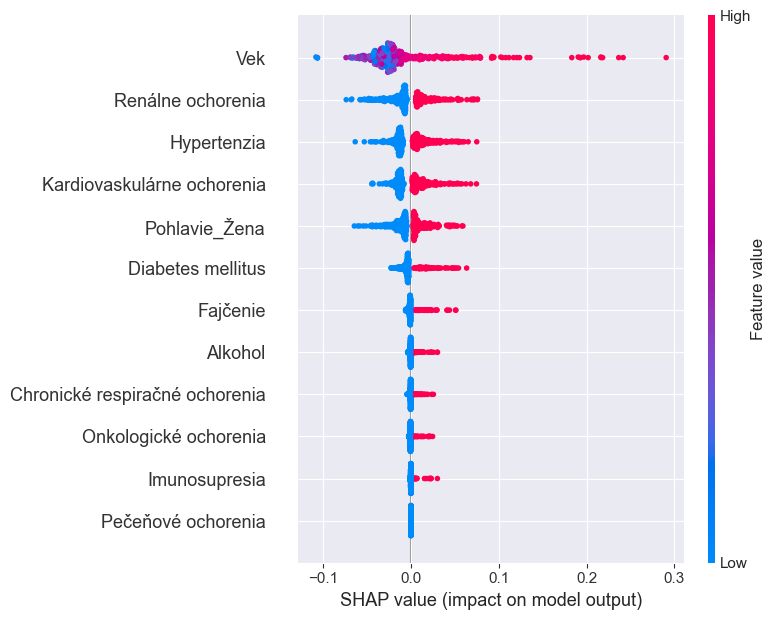

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters: {'classifier__C': 10, 'classifier__class_weight': None, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}


PermutationExplainer explainer: 379it [01:48,  3.16it/s]                         


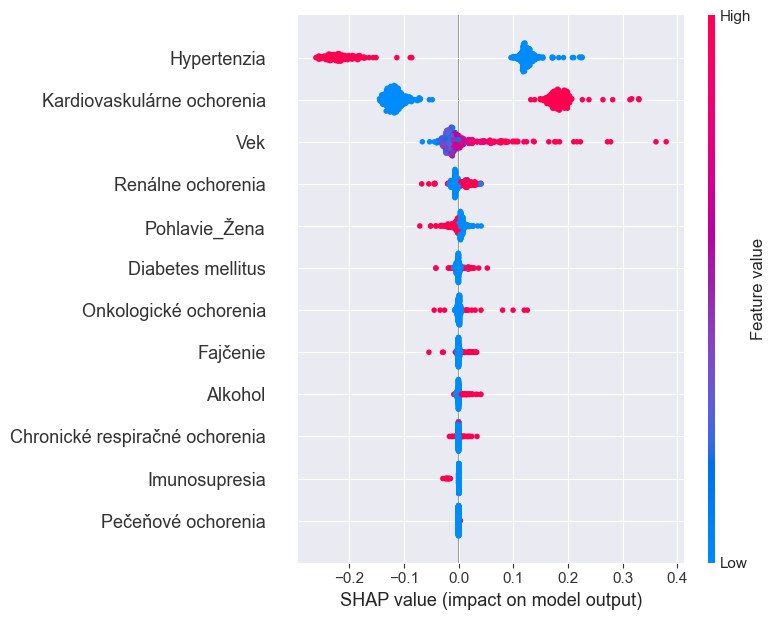


=== Hierarchical Metrics ===
H-Precision: 0.8017
H-Recall:    0.7886
H-F1:        0.7951


In [7]:
X, y_mortality, y_severity, y_true = preprocess_data('../data/3vlna.xlsx')
feature_names = X.columns

X_train, X_test, y_train_mort, y_test_mort = train_test_split(
    X, y_mortality, test_size=0.3, random_state=42, stratify=y_mortality
)

preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), ['Vek']),
    ('passthrough', 'passthrough', X.columns.difference(['Vek']))
])

mort_pipeline = train_svm(X_train, y_train_mort, preprocessor)

# Ak bol model úspešne natrénovaný, generujú sa SHAP hodnoty a ukladajú sa do súboru aj ako graf.
if mort_pipeline:
     generate_and_save_shap_svm(
         pipeline=mort_pipeline,
         X_train=X_train,
         feature_level="mortality",
         wave_id=3,
         shap_csv_filename="shap_values.csv",
         shap_image_filename=f"shap_summary_mortality_wave3.png",
         save=False  # Uloženie obrázka - v prípade potreby ho zmeňte na True
     )


oof_predictions = cross_val_predict(
    mort_pipeline, X_train, y_train_mort, cv=5, method='predict'
)
survivor_mask_train_pred_oof = (oof_predictions == 0)


y_train_severity_not_na_mask = y_severity.loc[X_train.index].notna()
relevant_mask_train = survivor_mask_train_pred_oof & y_train_severity_not_na_mask
X_train_severity = X_train[relevant_mask_train]
y_train_severity = y_severity.loc[X_train.index][relevant_mask_train]


severity_pipeline = train_svm(X_train_severity, y_train_severity, preprocessor)


if severity_pipeline:
    generate_and_save_shap_svm(
          pipeline=severity_pipeline,
          X_train=X_train_severity,
          feature_level="severity",
          wave_id=3,
          shap_csv_filename="shap_values.csv",
          shap_image_filename=f"shap_summary_severity_wave3.png",
          save=False  # Uloženie obrázka - v prípade potreby ho zmeňte na True
      )


y_pred_mortality_test = mort_pipeline.predict(X_test)
survivor_mask_test = (y_pred_mortality_test == 0)

X_test_severity = X_test[survivor_mask_test]
y_pred_severity = np.full(len(X_test), np.nan)


if not X_test_severity.empty:
    y_pred_severity_survivors = severity_pipeline.predict(X_test_severity)
    y_pred_severity[survivor_mask_test] = y_pred_severity_survivors + 1

final_pred = np.full(len(X_test), 3)
final_pred[survivor_mask_test] = y_pred_severity[survivor_mask_test]
final_pred = np.nan_to_num(final_pred, nan=3).astype(int)

y_true_final = y_true.loc[X_test.index]
evaluate_predictions(y_true_final, pd.Series(final_pred, index=X_test.index))


### `Štvrtá vlna pandémie`

> #### Vzhľadom na nevyvážené dáta bolo pre štvrtú vlnu pandémie dodatočne pridaných niekoľko nových hyperparametrov pre GridSearch. Bez tohto prístupu modely ignorovali triedu „2 - preložený na iné oddelenie“, čo viedlo k nesprávnym predpovediam pre túto kategóriu

In [11]:

def train_svm_update(X, y, preprocessor, scoring='f1_weighted', random_state=42):

    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        # ('resampler', SMOTE(random_state=random_state)),
        ('classifier', SVC(random_state=random_state, probability=True, class_weight='balanced'))
    ])

    param_grid = {
       'classifier__C': [0.1, 1, 10, 100],
        'classifier__kernel': ['linear', 'rbf', 'poly'],
        'classifier__gamma': ['scale', 'auto',0.001, 0.01, 1],
         'classifier__class_weight': [None, 'balanced', {0: 1, 1: 3}, {0: 1, 1: 5}],


    }

    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring=scoring,
        verbose=2,
        n_jobs=-1
    )

    grid.fit(X, y)
    print("Best parameters:", grid.best_params_)
    return grid.best_estimator_

In [12]:
X, y_mortality, y_severity, y_true = preprocess_data('../data/4vlna.xlsx')
feature_names = X.columns
X_train, X_test, y_train_mort, y_test_mort = train_test_split(
    X, y_mortality, test_size=0.3, random_state=42
)

preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), ['Vek']),
    ('passthrough', 'passthrough', X.columns.difference(['Vek']))
])

mort_pipeline = train_svm_update(X_train, y_train_mort, preprocessor)

oof_predictions = cross_val_predict(
    mort_pipeline, X_train, y_train_mort, cv=5, method='predict'
)
survivor_mask_train_pred_oof = (oof_predictions == 0)


y_train_severity_not_na_mask = y_severity.loc[X_train.index].notna()
relevant_mask_train = survivor_mask_train_pred_oof & y_train_severity_not_na_mask
X_train_severity = X_train[relevant_mask_train]
y_train_severity = y_severity.loc[X_train.index][relevant_mask_train]


severity_pipeline = train_svm_update(X_train_severity, y_train_severity, preprocessor)

y_pred_mortality_test = mort_pipeline.predict(X_test)
survivor_mask_test = (y_pred_mortality_test == 0)

X_test_severity = X_test[survivor_mask_test]
y_pred_severity = np.full(len(X_test), np.nan)

if not X_test_severity.empty:
    y_pred_severity_survivors = severity_pipeline.predict(X_test_severity)
    y_pred_severity[survivor_mask_test] = y_pred_severity_survivors + 1


final_pred = np.full(len(X_test), 3)
final_pred[survivor_mask_test] = y_pred_severity[survivor_mask_test]
final_pred = np.nan_to_num(final_pred, nan=3).astype(int)

y_true_final = y_true.loc[X_test.index]
evaluate_predictions(y_true_final, pd.Series(final_pred, index=X_test.index))


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters: {'classifier__C': 0.1, 'classifier__class_weight': {0: 1, 1: 5}, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters: {'classifier__C': 0.1, 'classifier__class_weight': {0: 1, 1: 3}, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}

=== Hierarchical Metrics ===
H-Precision: 0.7691
H-Recall:    0.7997
H-F1:        0.7841
